<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span><ul class="toc-item"><li><span><a href="#Обучение-линейной-регрессии-на-исходных-данных" data-toc-modified-id="Обучение-линейной-регрессии-на-исходных-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Обучение линейной регрессии на исходных данных</a></span></li><li><span><a href="#Обучение-линейной-регрессии-на-преобразованных-данных" data-toc-modified-id="Обучение-линейной-регрессии-на-преобразованных-данных-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обучение линейной регрессии на преобразованных данных</a></span></li><li><span><a href="#Проверка-на-большом-количестве-повторений" data-toc-modified-id="Проверка-на-большом-количестве-повторений-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Проверка на большом количестве повторений</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

Описание данных:
- **Признаки**: пол, возраст и зарплата застрахованного, количество членов его семьи.
- **Целевой признак**: количество страховых выплат клиенту за последние 5 лет.

## Загрузка данных

In [1]:
!pip install scikit-learn==0.24.2
!pip install pandas==1.3.2
!pip install numpy==1.20.3

import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
import html

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.max_rows = None
pd.options.display.max_columns = None

pd.options.display.width = None
!pip install -U sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


  Using cached scikit_learn-0.24.2-cp38-cp38-win_amd64.whl (6.9 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
  Using cached pandas-1.3.2-cp38-cp38-win_amd64.whl (10.2 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 0.26.1 requires graphviz, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 0.26.1 requires graphviz, which is not installed.


  Using cached numpy-1.20.3-cp38-cp38-win_amd64.whl (13.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
  Using cached sklearn-0.0-py2.py3-none-any.whl


In [2]:
def df_info(data_frame, nulls_percentage_round=1, deep_memory_usage=False):
    '''
    Выводит на экран общую информацию о таблице
    Входные параметры:
        data_frame             — таблица типа pd.DataFrame;
        nulls_percentage_round — знак, до которого происходит округление в столбце nulls_percentage отображаемой таблицы;
        deep_memory_usage      — глубокий анализ используемой памяти
    '''
    assert isinstance(data_frame, pd.DataFrame), 'Аргумент data_frame должен иметь тип pd.DataFrame'
    t = pd.concat(
        [
         
            data_frame.isna().sum().to_frame('nulls_count'),
            (100 * data_frame.isna().sum() / len(data_frame)).round(nulls_percentage_round).to_frame('nulls_percentage'),
            data_frame.dtypes.to_frame('dtype')
        ],
        axis=1
    )
    s = 'dtypes:'
    c = data_frame.dtypes.value_counts()
    for i in c.index:
        s += ' {0}({1})'.format(i, c[i])
    m = data_frame.memory_usage(deep=deep_memory_usage).sum()
    if int(m / 1024 ** 3):
        d, b = 1024 ** 3, 'GB'
    elif int(m / 1024 ** 2):
        d, b = 1024 ** 2, 'MB'
    else:
        d, b = 1024, 'KB'
    print(t)
    print('columns: ', data_frame.shape[1], ', rows: ', data_frame.shape[0], sep='')
    print(s)
    print('memory_usage: ', round(m / d, 1), '+ ' if not deep_memory_usage else ' ', b, sep='')

In [3]:
# Загрузка данных

# Возможные пути расположения файлов
filepaths = {
    'insurance': ['/datasets/insurance.csv', './insurance.csv', 'https://code.s3.yandex.net/datasets/insurance.csv']
}

# Загрузка данных по первому существующему пути
data_list = []
for dfname in filepaths.keys():
    for filepath in filepaths[dfname]:
        try:
            exec(dfname + ' = pd.read_csv(filepath)')
            exec(dfname + f'.name = "{dfname}"')
            exec(f'data_list.append({dfname})')
            print('Таблица ' + dfname + ' из файла ' + filepath + ' загружена в переменную ' + dfname)
            break
        except Exception:
            continue
    else:
        raise SystemExit('Файл с таблицей ' + dfname + ' не найден ни по одному из путей в списке filepaths')

Таблица insurance из файла https://code.s3.yandex.net/datasets/insurance.csv загружена в переменную insurance


Ознакомимся с загруженными данными.

In [4]:
insurance.head(5)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [5]:
df_info(insurance)

                   nulls_count  nulls_percentage    dtype
Пол                          0               0.0    int64
Возраст                      0               0.0  float64
Зарплата                     0               0.0  float64
Члены семьи                  0               0.0    int64
Страховые выплаты            0               0.0    int64
columns: 5, rows: 5000
dtypes: int64(3) float64(2)
memory_usage: 195.4+ KB


Таблица содержит категориальные и количественные признаки, имеющие числовой формат. Таблица не имеет пропусков.

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** Если матрцу признаков объектов $X$ умножить на обратимую матрицу $P$, то после переобучения модели линейной регресии, ее предсказания для $XP$ не будут отличаться от предсказаний для $X$ до переобучения.

**Обоснование:**

Запишем формулу обучения линейной регрессии для преобразованной матрицы признаков:

$$
w_P = \Big((X P)^T (X P)\Big)^{-1} (X P)^T y,
$$
где $w_P$ &mdash; преобразованный вектор весов линейной регресси.


Воспользуемся свойством транспонированных матриц $(A B)^T = A^T B^T$:

$$
w_P = \Big((X P)^T (X P)\Big)^{-1} (X P)^T y = \Big(P^T X^T X P\Big)^{-1} P^T X^T y.
$$

В полученном выражении произведение $X^T X$ дает квадратную матрицу. При этом, если матрица $X$ не содержит линейно-зависимых строк (коллинеарных признаков) или стролбцов, матрица $X^T X$ обратима. В этом случае, согласно свойству обратных матриц $(A B C)^{-1} = C^{-1} B^{-1} A^{-1}$, формулу обучения можно записать следюущим образом:

$$
w_P = \Big(P^T X^T X P\Big)^{-1} P^T X^T y = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y.
$$

Произведение $(P^T)^{-1} P^T = I$, где $I$ &mdash; единичная матрица. Упростим выражение для вычисления $w_P$:

$$
w_P = P^{-1} (X^T X)^{-1} X^T y = P^{-1} w.
$$

Вычислим вектор предсказаний $a_P$ для измененных признаков:

$$
a_P = X P w_P = X P P^{-1} w = X w.
$$

Ч.т.д.

---

Произведение $X P$ можно интерпретировать как разложение (проекцию) векторов-строк матрицы $X$ по базису пространства, образованного системой строк (столбцов) матрицы $P$. Если матрица $P$ является ортогональной ($P^T = P^{-1}$), такое произведение означает разложение векторов-строк матрицы $X$ по ортонормированному базису (с сохранением длины &mdash; поворот). В общем случае при умножении на обратимую матрицу преобразованный векторы признаков свою длину не сохраняют.

Данное умножение может бить использовано для простого шифрования-дешифрования данных с ключом-матрицей $P$. Однако, учитывая сказанное выше, на матрицу $P$ должны накладываться некоторые требования:
- модуль определителя матрицы не должен быть слишком мал;
- матрица не должна всего лишь переставлять признаки местами или просто менять их знак;
- матрица не должна существенно изменять масштаб признаков.

Представление матрицы, модуль определителя которой очень близок к 0, в формате с плавающей запятой и вычислительные операции с такой матрицей могут привести к накоплению значительных вычислительных ошибок.

Перестановка признаков в векторе $X$ без изменения их значений может достигаться с помощью некоторых матриц, состоящих только из 0 и +/-1. Например, следующая матрица имеет ненулевой определитель:

$$
P = \left(\begin{array}{cccc} 0 & 1 & 0\\-1 & 0 & 0\\0 & 0 & 1 \end{array}\right), det P = 1.
$$

Но произведение $X P$ (в данном примере n объектов с 3 признаками) не обеспечит сокрытия данных:

$$
\left(\begin{array}{cccc} -f_{01} & f_{00} & f_{02} \\ -f_{11} & f_{10} & f_{12} \\ & \vdots & \\ -f_{n1} & f_{n0} & f_{n2} \end{array}\right)
=
\left(\begin{array}{cccc} f_{00} & f_{01} & f_{02} \\ f_{10} & f_{11} & f_{12} \\ & \vdots & \\ f_{n0} & f_{n1} & f_{n2} \end{array}\right)
\left(\begin{array}{cccc} 0 & 1 & 0\\-1 & 0 & 0\\0 & 0 & 1 \end{array}\right).
$$

Значительное изменение масштаба признаков также может снизить качество предсказания модели машинного обучения.

## Алгоритм преобразования

Для генерации квадратной обратимой матрицы воспользуемся генератором случайных чисел. Если каждый элемент сгенерированной матрицы будет представлять собой случайную нормально распределенную величину с математическим ожиданием 0 и дисперсией 1, то такая матрица с большой вероятностью будет обратимой, а также будет отвечать установленным в предыдущем пункте требованиям. Для проверки обратимости будем сверять ранг сгенерированной матрицы с ее размером.

In [6]:
np.random.normal(size=(4, 4))

array([[ 0.3069638 ,  0.94220943, -1.19773787,  0.16241642],
       [ 0.32341305, -1.9065062 ,  1.13115815,  0.1787571 ],
       [-2.0111262 , -0.11455209, -0.70833639, -1.03360455],
       [ 0.06767799,  0.27176493,  0.8920773 ,  0.65277017]])

In [7]:
def invertible_square_matrix(ds):
    '''
    Функция возвращает квадратную инвертируемую матрицу размером ds
    '''
    assert ds > 0, 'Выходнй размер диагонали матрицы ds должен быть больше 0'
    r = 0
    while r < ds:
        m = np.random.normal(0, 1, size=(ds, ds))
        r = np.linalg.matrix_rank(m)
    return m

def features_transform(df, m):
    '''
    Функция возвращает копию таблицы df, каждый объект которой умножен на матрицу m
    '''
    return pd.DataFrame(data=df.values @ m, index=df.index, columns=df.columns)

## Проверка алгоритма

### Обучение линейной регрессии на исходных данных

Обучим модель линейной регрессии на исходной выборке данных. Проверим качество ее предсказания с помощью R2 метрики.

In [8]:
TARGET = 'Страховые выплаты'
FEATURES = insurance.columns.values[insurance.columns.values != TARGET]

In [9]:
lr_gs = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={},
    scoring='r2',
    refit=True,
    verbose=3
)
lr_gs.fit(insurance[FEATURES], insurance[TARGET])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.401 total time=   0.0s
[CV 2/5] END ..................................., score=0.447 total time=   0.0s
[CV 3/5] END ..................................., score=0.416 total time=   0.0s
[CV 4/5] END ..................................., score=0.415 total time=   0.0s
[CV 5/5] END ..................................., score=0.437 total time=   0.0s


GridSearchCV(estimator=LinearRegression(), param_grid={}, scoring='r2',
             verbose=3)

In [10]:
lr_gs.cv_results_

{'mean_fit_time': array([0.02943025]),
 'std_fit_time': array([0.05218358]),
 'mean_score_time': array([0.00053463]),
 'std_score_time': array([0.00065812]),
 'params': [{}],
 'split0_test_score': array([0.40104201]),
 'split1_test_score': array([0.44663077]),
 'split2_test_score': array([0.41583058]),
 'split3_test_score': array([0.41470783]),
 'split4_test_score': array([0.43735766]),
 'mean_test_score': array([0.42311377]),
 'std_test_score': array([0.01653363]),
 'rank_test_score': array([1])}

R2 метрика.

In [11]:
r2_score = lr_gs.score(insurance[FEATURES], insurance[TARGET])
r2_score

0.42494550286668

### Обучение линейной регрессии на преобразованных данных

Обучим модель линейной регрессии на преобразованных признаках объектов.

In [12]:
m = invertible_square_matrix(insurance.values.shape[1]-1)
print('Матрица:')
print(m)
print('\nОпределитель:')
print(np.linalg.det(m))
insurance_transformed_features = features_transform(insurance[FEATURES], m)
print('\nПреобразованные признаки:')
insurance_transformed_features.head()

Матрица:
[[-0.71502482  0.75074423  0.72316315 -0.71587805]
 [-1.93004211 -0.33862879  0.11873514  0.38658227]
 [-0.72529852 -1.45040158  0.83059646  1.32962524]
 [ 0.63066492 -0.65898511  0.10502839  1.24213351]]

Определитель:
2.022003877500541

Преобразованные признаки:


,Пол,Возраст,Зарплата,Члены семьи
0,-36054.022899,-71953.710240,41203.280529,65965.788045
1,-27649.495201,-55131.495835,31568.232156,50544.784047
2,-15287.240235,-30468.253352,17445.968886,27933.340931
3,-30284.218024,-60490.174935,34638.575692,55455.975013
4,-18985.047692,-37864.212021,21682.615237,34713.327196


In [13]:
lr_gs_2 = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={},
    scoring='r2',
    refit=True,
    verbose=3
)
lr_gs_2.fit(insurance_transformed_features, insurance[TARGET])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.401 total time=   0.0s
[CV 2/5] END ..................................., score=0.447 total time=   0.0s
[CV 3/5] END ..................................., score=0.416 total time=   0.0s
[CV 4/5] END ..................................., score=0.415 total time=   0.0s
[CV 5/5] END ..................................., score=0.437 total time=   0.0s


GridSearchCV(estimator=LinearRegression(), param_grid={}, scoring='r2',
             verbose=3)

In [14]:
lr_gs_2.cv_results_

{'mean_fit_time': array([0.00368977]),
 'std_fit_time': array([0.00055347]),
 'mean_score_time': array([0.00039201]),
 'std_score_time': array([0.00048166]),
 'params': [{}],
 'split0_test_score': array([0.40104201]),
 'split1_test_score': array([0.44663077]),
 'split2_test_score': array([0.41583058]),
 'split3_test_score': array([0.41470783]),
 'split4_test_score': array([0.43735766]),
 'mean_test_score': array([0.42311377]),
 'std_test_score': array([0.01653363]),
 'rank_test_score': array([1])}

R2 метрика.

In [15]:
r2_score_2 = lr_gs_2.score(insurance_transformed_features, insurance[TARGET])
r2_score_2

0.42494550286667876

Модуль разницы между R2 для моделей линейной регрессии, обученных на исходных и преобразованных признаках.

In [16]:
abs(r2_score - r2_score_2)

1.2212453270876722e-15

Полученная разница находится на уровне накопленной ошибки вычисления.

### Проверка на большом количестве повторений

Проанализируем разброс ошибки &mdash; модуля разности значения R2 для модели линейной регресии, обученной на исходных признаках, и R2 для модели линейной регрессии, обученной на преобразованных признаках с использованием 1000 различных матриц преобразования.

In [17]:
det_3 = []
error_3 = []

n = 1000
for _ in range(n):
    # Преобразование признаков
    m = invertible_square_matrix(insurance.values.shape[1]-1)
    det_3.append(np.linalg.det(m))
    insurance_transformed_features = features_transform(insurance[FEATURES], m)
    # Обучение модели и вычисление метрики качества
    lr_gs_3 = GridSearchCV(
        estimator=LinearRegression(),
        param_grid={},
        scoring='r2',
        refit=True,
        verbose=0
    )
    lr_gs_3.fit(insurance_transformed_features, insurance[TARGET])
    r2_score_3 = lr_gs_3.score(insurance_transformed_features, insurance[TARGET])
    error_3.append(abs(r2_score_3 - r2_score_2))

error_3 = pd.Series(error_3)
det_3 = pd.Series(det_3)

In [18]:
error_3.describe()

count    1.000000e+03
mean     3.283829e-14
std      6.128069e-13
min      0.000000e+00
25%      1.443290e-15
50%      3.996803e-15
75%      1.043610e-14
max      1.934441e-11
dtype: float64

Максимальное значение ошибки не превышает 1e-9, что по-прежнему лежит на уровне накопленной ошибки вычисления.

Исследуем зависимость вычисленных ошибок от определителя матрицы преобразования.

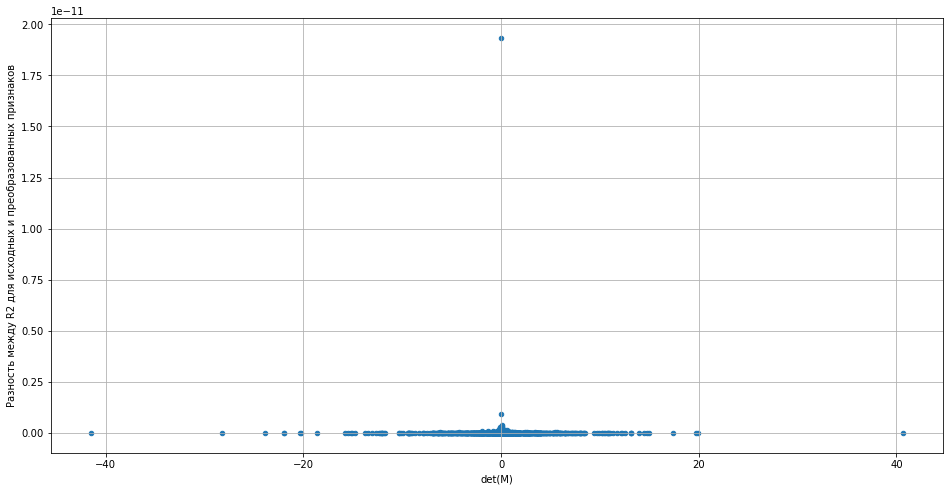

In [19]:
xlabel = 'det(M)'
ylabel = 'Разность между R2 для исходных и преобразованных признаков'
pd.concat(
    [
        det_3.to_frame(xlabel),
        error_3.to_frame(ylabel)
    ],
    axis=1
).plot.scatter(
    x=xlabel,
    y=ylabel,
    figsize=(16,8),
    grid='on'
);

На построенной диаграмме разброса видно, что значение ошибки практически не зависит от значения определителя матрицы преобразования. За редким исключением ошибки постоянны и близки к 0.

Только для значений определителя матрицы преобразования в окрестностях нуля наблюдается незначительный рост ошибок. Это также объясняется потерей точности при представлении малых чисел в формате с плавающей запятой и, как следствие, накоплением ошибки вычисления.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные загружены
- [x]  Выполнен шаг 2: получен ответ на вопрос об умножении матриц
    - [x]  Указан правильный вариант ответа
    - [x]  Вариант обоснован
- [x]  Выполнен шаг 3: предложен алгоритм преобразования
    - [x]  Алгоритм описан
    - [x]  Алгоритм обоснован
- [x]  Выполнен шаг 4: алгоритм проверен
    - [x]  Алгоритм реализован
    - [x]  Проведено сравнение качества моделей до и после преобразования